In [88]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [89]:
train_dat = pd.read_csv("recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv")
train_dat

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
...,...,...,...,...,...,...,...,...,...
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0
798,109,139,28.1,66,94,0.2298,53,1,0


Peaking at the data we can see that we have some missing data we need to remove (if you have a blood sugar level, blood pressure, or bmi of 0 you are most likely dead). 

In [90]:
train_dat = train_dat[train_dat.weight != 0]
train_dat = train_dat[train_dat.bmi!= 0]
train_dat = train_dat[train_dat.blood_pressure != 0]
train_dat = train_dat[train_dat.cardio_stress_test != 0]
train_dat = train_dat[train_dat.insulin_test != 0]
train_dat = train_dat[train_dat.liver_stress_test != 0]

x_train = train_dat.iloc[:,0:8]
y_train = train_dat["zeta_disease"]

train_dat

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
1,23,150,38.5,68,71,0.3868,55,2,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
6,20,154,27.8,64,116,0.5168,53,0,0
7,37,167,34.5,88,145,0.4658,54,1,1
...,...,...,...,...,...,...,...,...,...
792,56,239,30.1,60,846,0.4608,53,1,1
793,22,118,25.0,70,66,0.2498,62,2,0
794,46,176,38.5,88,108,0.4118,66,8,0
795,26,161,28.4,90,78,0.5578,42,3,0


This is a pretty big hit to our sample size. If I had more context I may try to inpute, but this can seriously bias our data, and 400 is still a pretty good sample size, some I'm inclined to work with the subset rather than risk biasing my model.

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'weight'),
 Text(2.5, 0, 'bmi'),
 Text(3.5, 0, 'blood_pressure'),
 Text(4.5, 0, 'insulin_test'),
 Text(5.5, 0, 'liver_stress_test'),
 Text(6.5, 0, 'cardio_stress_test'),
 Text(7.5, 0, 'years_smoking'),
 Text(8.5, 0, 'zeta_disease')]

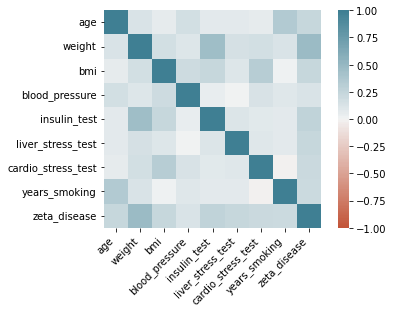

In [91]:
corr = train_dat.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

The initial exploration of the data suggests some moderate correlations with a number of variables, especially weight. Nothing stands out as particularly troublesome as far as covaraince between predictors. The covariance between predictors is low enough that it is very unlikely that interaction terms are going to be useful. A simple logit model may be a pretty good fit given the low number of variables. It also has the advantage of retaining scrutability.

Below I'm going to:
 - Begin with the full model with all variables. I'm using statsmodel instead of sklearn because it gives me easy access to summaries of my model. One note here is that statsmod does true logistic regression, where sklearn uses l2 peanalizatoin by default. So the results may be slightly different.
 - I'll evaluate variables with their z-values and associated p-values and decide which to drop.
 - I will use BIC (Bayesian informatoin criterion) as my main measure of model fit, as it penalizes complex models and keeps over-fitting under control.
 - I could "automate" this process with a function for backward selection, but given the small number of variables, I like to be able to go through them manually and decide if what is happening makes substantive sense. 
 - Prefer backwards selection over forward selection because you quickly see if things aren't working (because p-values and coefficients will change wildely when you drop a variable)

In [92]:
full_mod = sm.Logit(y_train,x_train).fit()
print(full_mod.summary())
print("BIC:",full_mod.bic)


Optimization terminated successfully.
         Current function value: 0.590373
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      421
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.07249
Time:                        21:34:37   Log-Likelihood:                -253.27
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 1.508e-06
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                    0.0131      0.008      1.672      0.094      -0.002       0.029
weigh

BMI is a poor predictor, and may be stealing significance from weight. Cardio stress test is also clearly non significant.

In [93]:
x_train = x_train.drop(["bmi","cardio_stress_test"],axis=1)

reduced_mod_1 = sm.Logit(y_train,x_train).fit()
print(reduced_mod_1.summary())
print("BIC:",reduced_mod_1.bic)


Optimization terminated successfully.
         Current function value: 0.590583
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      423
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.07216
Time:                        21:34:38   Log-Likelihood:                -253.36
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 1.965e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                   0.0132      0.008      1.685      0.092      -0.002       0.029
weight  

This model does improve the BIC, suggesting it is a more parsimonious model. We now see age is clearly non-significant, as is the liver stress test. We'll remove those

In [94]:
x_train = x_train.drop(["age","liver_stress_test"],axis=1)

reduced_mod_2 = sm.Logit(y_train,x_train).fit()
print(reduced_mod_2.summary())
print("BIC:",reduced_mod_2.bic)

Optimization terminated successfully.
         Current function value: 0.598103
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  429
Model:                          Logit   Df Residuals:                      425
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.06035
Time:                        21:34:38   Log-Likelihood:                -256.59
converged:                       True   LL-Null:                       -273.06
Covariance Type:            nonrobust   LLR p-value:                 3.288e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
weight             0.0076      0.003      2.666      0.008       0.002       0.013
blood_pressure   

Our BIC is substantially improved here, and this model intuitvely makes more sense as it uses the underlying medical conditions, not noisy measurements of those conditions. We did keep the insulin test, which may measure things other than weight and years smoking. I tried dropping it, but it did not improve the model. So, baring more informatoin, I'm leaving it for now.

The code below outputs predictions for the 20 test data points. I'm leaving them in probability format. We could turn these into "hard predictions" based on a cutoff. However, the cutoff to choose is dependant on disease prevalance in the population, allocation of treatement resources etc. An ROC curve would give us some practical emperical informatoin about what a good cutoff may be, but more information from shareholders would be needed to make this decision. 

In [95]:
test_dat = pd.read_csv("recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv")
x_test = test_dat[["weight","blood_pressure","years_smoking"]]
print("Predictions for our twenty points:")
final_mod.predict(x_test)

Predictions for our twenty points:


0     0.319561
1     0.254636
2     0.223692
3     0.462317
4     0.597813
5     0.124129
6     0.342082
7     0.333391
8     0.570252
9     0.273082
10    0.539876
11    0.422778
12    0.186425
13    0.356171
14    0.215035
15    0.634123
16    0.186754
17    0.607487
18    0.406685
19    0.124536
dtype: float64